<a href="https://colab.research.google.com/github/katyalelas/NLP/blob/main/AffectiveComputing_NLP_sentiment_subjectivity_topicmodeling_Klelas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project for the course Affective Computing at Algebra UC
"NLP - sentimet analysis and topic modeling with TextBlob, LDP"



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import random
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from textblob import Word

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Part one: Twitter data. Analysis of 3200 most recent tweets of the user @UN.** 

  

> I used TextBlob library to give polarity and subjectivity scores to the tweets of the @UN user, also based on the number of retweets and likes I assigned a feature "popular" indicating if a tweet has collected more than average number of likes and retweets all together and applied a simple binary classification machine learning models. The data preprocessing was made in few steps using noise removal with regular expressions, normalization, in particular stemming and lemmatization with libraries , and tokenization


 

# Collect data from twitter

In [4]:
ACCESS_TOKEN="1114257900657106945-1dCAiAhqC8Dn7N0SYchfrcPBJNnO3R"
ACCESS_TOKEN_SECRET="9q6svuksiWxwxYggI5hVWgY8ZLrXESSMUAnGYNkEp97By"
CONSUMER_SECRET="g4CkmDKmbv2jNxm2yQOmth8NWOthgCgDSZGP1vBRuP5v4g6ZhD"
CONSUMER_KEY="eOqXos4xUTFpuv0uxPYCvRIpH"

In [ ]:
def twitter_setup():
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) # Authorization to consumer key and consumer secret
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET) # Access to user's access key and access secret 
    api = tweepy.API(auth)  # Return API with authentication:
    return api    
api=twitter_setup()

In [ ]:

def get_all_tweets(screen_name):
    alltweets = []  
    new_tweets = api.user_timeline(screen_name = screen_name, count=200) # (200 is the maximum allowed count)    
    alltweets.extend(new_tweets) # save recent tweets
    oldest = alltweets[-1].id - 1  #save the id of the oldest tweet less one
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)  #all subsiquent requests use the max_id param to prevent duplicates
        alltweets.extend(new_tweets) 
        oldest = alltweets[-1].id - 1   #update the id of the oldest tweet less one
        print(f"...{len(alltweets)} tweets downloaded so far")
        
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.retweet_count, tweet.favorite_count, tweet.in_reply_to_screen_name, tweet.source, tweet.user.followers_count, tweet.user.friends_count] for tweet in alltweets]
     #transform the tweepy tweets into a 2D array that will populate the csv 

    return outtweets 
   

In [ ]:
UN=get_all_tweets("un")

getting tweets before 1351127733120720897
...400 tweets downloaded so far
getting tweets before 1345415306345373698
...600 tweets downloaded so far
getting tweets before 1339684796537188359
...800 tweets downloaded so far
getting tweets before 1335351153115205633
...1000 tweets downloaded so far
getting tweets before 1330602450680733699
...1200 tweets downloaded so far
getting tweets before 1326162959492648959
...1400 tweets downloaded so far
getting tweets before 1321436153254453249
...1600 tweets downloaded so far
getting tweets before 1316983210149031935
...1800 tweets downloaded so far
getting tweets before 1312119890073939967
...2000 tweets downloaded so far
getting tweets before 1308481561554280447
...2200 tweets downloaded so far
getting tweets before 1303635257116315647
...2400 tweets downloaded so far
getting tweets before 1298018496870338564
...2600 tweets downloaded so far
getting tweets before 1292944311546449929
...2800 tweets downloaded so far
getting tweets before 128728

In [ ]:
# assign column names to the dataset
df_UN = pd.DataFrame.from_records(UN, columns=['tweet_id','created_at', 'text', 'retweet_count','favorite_count','in_reply_to_screen_name', 'source', 'followers_count', 'friends_count'] )
df_UN.shape

(3200, 9)

In [ ]:
df_UN.to_csv('UN_01022021.csv', header=True) # save the file

In [7]:
from google.colab import drive # mount google drive
drive.mount('drive')

Mounted at drive


In [ ]:
!cp UN_01022021.csv "drive/My Drive/" # save the file to google drive

In [9]:
df_UN=pd.read_csv('drive/My Drive/UN_01022021.csv') # read the file from google drive

In [ ]:
df_UN.head(10)

,Unnamed: 0,tweet_id,created_at,text,retweet_count,favorite_count,in_reply_to_screen_name,source,followers_count,friends_count
0,0,1356317393048506369,2021-02-01 19:04:00,Recognition\nJustice\nDevelopment\n\n#BlackHis...,47,158,NaN,TweetDeck,13428261,1184
1,1,1356302735780548608,2021-02-01 18:05:45,RT @UNmigration: “COVID-19 has tragically exac...,11,0,NaN,Twitter Web App,13428261,1184
2,2,1356287104679075840,2021-02-01 17:03:39,"In times of crisis, women are leaders in their...",86,222,NaN,Twitter for iPhone,13428261,1184
3,3,1356256620091736068,2021-02-01 15:02:30,RT @UN_Spokesperson: .@antonioguterres strongl...,306,0,NaN,Twitter Web App,13428261,1184
4,4,1356240214524624901,2021-02-01 13:57:19,The United Kingdom assumes the presidency of t...,115,445,NaN,Twitter for iPhone,13428261,1184
5,5,1356224683214053377,2021-02-01 12:55:36,RT @UN_Women: Happy #BlackHistoryMonth!\n\nThi...,256,0,NaN,Twitter Web App,13428261,1184
6,6,1356061204637048834,2021-02-01 02:06:00,The Champions of the Earth take #ClimateAction...,63,254,NaN,TweetDeck,13428261,1184
7,7,1356015151384682498,2021-01-31 23:03:00,Nearly 1 in 10 children are subjected to child...,134,354,NaN,TweetDeck,13428261,1184
8,8,1355971111163334657,2021-01-31 20:08:00,The climate crisis has not stopped amid #COVID...,98,287,NaN,TweetDeck,13428261,1184
9,9,1355925057881698306,2021-01-31 17:05:00,"""Now is the time to secure the well-being of p...",207,626,NaN,TweetDeck,13428261,1184


In [ ]:
df_UN.dtypes

Unnamed: 0                  int64
tweet_id                    int64
created_at                 object
text                       object
retweet_count               int64
favorite_count              int64
in_reply_to_screen_name    object
source                     object
followers_count             int64
friends_count               int64
dtype: object

In [10]:
df_UN['created_at']= pd.to_datetime(df_UN['created_at'])

In [ ]:
df_UN.dtypes

Unnamed: 0                          int64
tweet_id                            int64
created_at                 datetime64[ns]
text                               object
retweet_count                       int64
favorite_count                      int64
in_reply_to_screen_name            object
source                             object
followers_count                     int64
friends_count                       int64
dtype: object

In [ ]:
df_UN.columns

Index(['Unnamed: 0', 'tweet_id', 'created_at', 'text', 'retweet_count',
       'favorite_count', 'in_reply_to_screen_name', 'source',
       'followers_count', 'friends_count'],
      dtype='object')

In [11]:
df_UN=df_UN.drop(columns=['Unnamed: 0'])

In [12]:
df_UN['tweet_id'] = df_UN['tweet_id'].astype(str)

In [ ]:
from datetime import datetime
datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')


In [ ]:
df_UN.shape

(3209, 10)

In [ ]:
df_UN.created_at.describe() # the dataset includes 3209 tweets from @UN user for the period from 24-06-2020 17:05 till 01-02-2021 19:04

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    3209
unique                   3209
top       2020-09-29 17:05:00
freq                        1
first     2020-06-24 04:03:00
last      2021-02-01 19:04:00
Name: created_at, dtype: object

In [ ]:
3209-2796

413

In [ ]:
df_UN[df_UN['created_at']<datetime.datetime(2021,1,1)].created_at.describe() # 413 tweets were posted during the period of one month from 01-01-2021 00:00 till 01-02-2021 19:04

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2796
unique                   2796
top       2020-09-29 17:05:00
freq                        1
first     2020-06-24 04:03:00
last      2020-12-31 23:51:54
Name: created_at, dtype: object

# Analysis of likes 

In [ ]:
df_UN.favorite_count.describe() # the mean number of likes per tweet is 301, standard deviation is 1112.

count     3209.000000
mean       300.922406
std       1112.202376
min          0.000000
25%          0.000000
50%        207.000000
75%        376.000000
max      44321.000000
Name: favorite_count, dtype: float64

In [ ]:
df_UN[df_UN['created_at']<datetime.datetime(2021,1,1)].favorite_count.describe()
 # we could remove the last month considering that the number of likes can be dependent on the time, i.e. how long the tweet has been online.
 # one can assume that very recent tweets can have small number of likes because they have not been seen my all the followers yet. 
 # however, removing one last month from the dataset has given almost the same statistical analysis, with the mean value of 300 and standard deviation of 1179.

count     2796.000000
mean       300.005722
std       1179.835494
min          0.000000
25%          0.000000
50%        203.000000
75%        368.000000
max      44321.000000
Name: favorite_count, dtype: float64

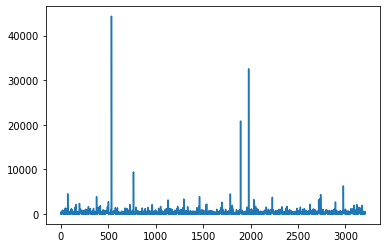

In [ ]:
df_UN.favorite_count.plot()

In [ ]:
def outliers(col, df):
  max=col.mean() + 3*col.std()
  min=col.mean() - 3*col.std()
  print('upper limit = ', max, ', lower limit = ', min)
  newdf=df[(col<max)&(col>min)]
  print('new dataframe shape = ', newdf.shape)
  print('number of rows removed =', df.shape[0]-newdf.shape[0])
  print('statistic: \n', newdf.describe())
  return newdf

In [ ]:
ndf=outliers(df_UN.favorite_count, df_UN) # after removal of outliers the mean value is 258 and std is 335

upper limit =  3637.5295346174316 , lower limit =  -3035.684723149685
new dataframe shape =  (3198, 9)
number of rows removed = 11
statistic: 
        retweet_count  favorite_count  followers_count  friends_count
count    3198.000000     3198.000000           3198.0         3198.0
mean      218.368668      258.784553       13428261.0         1184.0
std       916.562973      335.239124              0.0            0.0
min         1.000000        0.000000       13428261.0         1184.0
25%        67.000000        0.000000       13428261.0         1184.0
50%       105.000000      207.000000       13428261.0         1184.0
75%       195.000000      373.000000       13428261.0         1184.0
max     40435.000000     3485.000000       13428261.0         1184.0


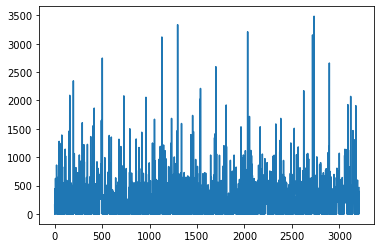

In [ ]:
ndf.favorite_count.plot()

# Analysis of retweets

In [ ]:
df_UN.retweet_count.describe()

count     3209.000000
mean       230.869430
std        974.597804
min          1.000000
25%         67.000000
50%        105.000000
75%        196.000000
max      40435.000000
Name: retweet_count, dtype: float64

In [ ]:
df_UN[df_UN['created_at']<datetime.datetime(2021,1,1)].retweet_count.describe()

count     2796.000000
mean       235.008226
std       1037.782155
min          2.000000
25%         66.750000
50%        104.000000
75%        193.250000
max      40435.000000
Name: retweet_count, dtype: float64

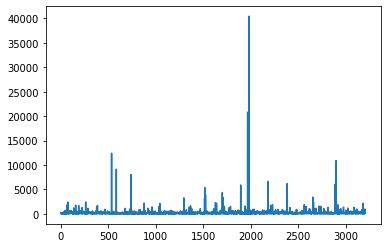

In [ ]:
df_UN.retweet_count.plot()

In [ ]:
ndf=outliers(df_UN.retweet_count, df_UN) # mean is 179, std is 239

upper limit =  3154.6628430038118 , lower limit =  -2692.9239835460367
new dataframe shape =  (3190, 9)
number of rows removed = 19
statistic: 
        retweet_count  favorite_count  followers_count  friends_count
count    3190.000000     3190.000000           3190.0         3190.0
mean      179.017241      271.055486       13428261.0         1184.0
std       238.702247      418.395807              0.0            0.0
min         1.000000        0.000000       13428261.0         1184.0
25%        67.000000        0.000000       13428261.0         1184.0
50%       104.000000      209.000000       13428261.0         1184.0
75%       194.000000      376.000000       13428261.0         1184.0
max      2444.000000     9401.000000       13428261.0         1184.0


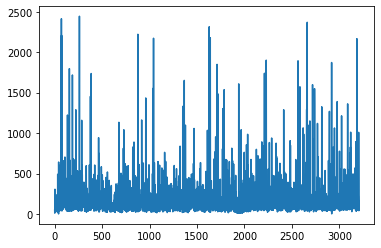

In [ ]:
ndf.retweet_count.plot()

# Is a tweet popular?

In [ ]:
df_UN[(df_UN.retweet_count>179)&(df_UN.favorite_count>258)].describe() 

In [ ]:
print('fraction of popular tweets where number of retweets & likes is bigger than the mean value (179 & 258 respectfully) is: \n ', round(457/3209*100, 2), '%')

fraction of popular tweets where number of retweets & likes is bigger than the mean value (179 & 258 respectfully) is: 
  14.24 %


In [175]:
df_UN['popular'] = np.where((df_UN.retweet_count>179)&(df_UN.favorite_count>258), 1, 0)

In [11]:
df_UN.describe()

,retweet_count,favorite_count,followers_count,friends_count,popular
count,3209.000000,3209.000000,3209.0,3209.0,3209.000000
mean,230.869430,300.922406,13428261.0,1184.0,0.142412
std,974.597804,1112.202376,0.0,0.0,0.349527
min,1.000000,0.000000,13428261.0,1184.0,0.000000
25%,67.000000,0.000000,13428261.0,1184.0,0.000000
50%,105.000000,207.000000,13428261.0,1184.0,0.000000
75%,196.000000,376.000000,13428261.0,1184.0,0.000000
max,40435.000000,44321.000000,13428261.0,1184.0,1.000000


In [ ]:
df_UN[df_UN.popular==1].created_at.describe() # in the sample of only popular tweets there are those created in the last month as well as on the day before the dataset was generated
# the latest "popular" tweet was published on 31-01-2021 at 17:05 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     457
unique                    457
top       2021-01-31 17:05:00
freq                        1
first     2020-06-25 00:03:00
last      2021-01-31 17:05:00
Name: created_at, dtype: object

In [ ]:
df_UN[df_UN.popular==0].created_at.describe()  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2752
unique                   2752
top       2020-09-29 17:05:00
freq                        1
first     2020-06-24 04:03:00
last      2021-02-01 19:04:00
Name: created_at, dtype: object

In [ ]:
# tweets created at 01-02-2021
df_UN[df_UN['created_at']>=datetime.datetime(2021,2,1)].describe()

,retweet_count,favorite_count,followers_count,friends_count,popular
count,7.000000,7.000000,7.0,7.0,7.0
mean,126.285714,154.142857,13428261.0,1184.0,0.0
std,111.396760,168.557041,0.0,0.0,0.0
min,11.000000,0.000000,13428261.0,1184.0,0.0
25%,55.000000,0.000000,13428261.0,1184.0,0.0
50%,86.000000,158.000000,13428261.0,1184.0,0.0
75%,185.500000,238.000000,13428261.0,1184.0,0.0
max,306.000000,445.000000,13428261.0,1184.0,0.0


In [ ]:
# tweets created at 31-01-2021
df_UN[(df_UN['created_at']>=datetime.datetime(2021,1,31))&(df_UN['created_at']<datetime.datetime(2021,2,1))].describe()

,retweet_count,favorite_count,followers_count,friends_count,popular
count,8.000000,8.000000,8.0,8.0,8.000000
mean,97.625000,325.625000,13428261.0,1184.0,0.125000
std,51.163429,127.754158,0.0,0.0,0.353553
min,49.000000,223.000000,13428261.0,1184.0,0.000000
25%,66.500000,262.000000,13428261.0,1184.0,0.000000
50%,80.500000,287.500000,13428261.0,1184.0,0.000000
75%,107.000000,323.250000,13428261.0,1184.0,0.000000
max,207.000000,626.000000,13428261.0,1184.0,1.000000


In [50]:
for tweet in df_UN.text[500:515]:
    print(tweet)
    print('/////////////////////////////////////////////////////////////////////')

#FBF to 2014 when children displaced from their homes by violence and conflict in South Sudan sang Christmas carols… https://t.co/CDoeojN5eK
/////////////////////////////////////////////////////////////////////
RT @WFP: A little reminder for this year's holiday cooking: keep #foodwaste to a minimum!

🍞Buy only what you need
🍲Eat leftovers
🥧 Share t…
/////////////////////////////////////////////////////////////////////
#MerryChristmas to all who are celebrating! https://t.co/8JO2jqBgDL
/////////////////////////////////////////////////////////////////////
RT @UNICEF: Got questions about wearing a mask? You’re not alone. Check out this expert advice on how to help your family stop the spread o…
/////////////////////////////////////////////////////////////////////
RT @UNDP: Make your holiday season a #ZeroWaste #HolidaySeason at home. Even in a pandemic we can take eco-friendly steps for healthier com…
/////////////////////////////////////////////////////////////////////
#YearInReview: On 

## Noise reduction / data cleaning

In [14]:
def cleaning(text_column):
  clean_tweets=[]
  for tweet in text_column:
    tweet=re.sub(r'@[A-Za-z0-9]+','',tweet) # Remove @username
    tweet=re.sub('https?://[A-Za-z0-9./]+','', tweet) # Remove https links
    tweet = re.sub(r'\b\w{1,3}\b', '', tweet) # Remove small words
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')  # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = re.sub(r'\&\w*;', '', tweet) # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub('[!@$#:]', '', tweet) # Remove some special characters
  #  tweet=re.sub("this|that|their|than|your|This|That", "", tweet)
   # tweet = re.sub(r'#\w*', '', tweet) # Remove hashtags
    tweet=re.sub('[^A-Za-z0-9]+', ' ', tweet) #Remove all characters except numbers and letters
    tweet = tweet.strip(' ') # Removing the blank space 
    tweet = tweet.lower()
    clean_tweets.append(tweet)

  print(clean_tweets[:5])
  return clean_tweets

In [14]:
ct=cleaning(df_UN.text)

['recognition justice development blackhistorymonth gets underway monday opportunity fightracism lear', 'covid tragically exacerbated suffering insecurity facing hundreds millions people needs', 'times crisis women leaders their communities frontline response services women explains', 'spokesperson strongly condemns detention aung president myint other political', 'united kingdom assumes presidency security council month february follow newyork']


In [51]:
len(ct)

3209

In [56]:
for tweet, ct_ in zip (df_UN.text[500:515], ct[500:515]):
    print("\n Original tweet:", tweet, "\n Cleaned tweet: ", ct_)
    print('/////////////////////////////////////////////////////////////////////')


 Original tweet: #FBF to 2014 when children displaced from their homes by violence and conflict in South Sudan sang Christmas carols… https://t.co/CDoeojN5eK 
 Cleaned tweet:  2014 when children displaced from their homes violence conflict south sudan sang christmas carols
/////////////////////////////////////////////////////////////////////

 Original tweet: RT @WFP: A little reminder for this year's holiday cooking: keep #foodwaste to a minimum!

🍞Buy only what you need
🍲Eat leftovers
🥧 Share t… 
 Cleaned tweet:  little reminder this year holiday cooking keep foodwaste minimum only what need leftovers share
/////////////////////////////////////////////////////////////////////

 Original tweet: #MerryChristmas to all who are celebrating! https://t.co/8JO2jqBgDL 
 Cleaned tweet:  merrychristmas celebrating
/////////////////////////////////////////////////////////////////////

 Original tweet: RT @UNICEF: Got questions about wearing a mask? You’re not alone. Check out this expert advic

In [21]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import PorterStemmer 

# Stemming

In [22]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer("english")

In [23]:
# Tokenize and lemmatize
def lemmatize_stemming(text, stemmer):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
  

In [24]:
def preprocess(text, stemmer):
    result=[]
    for token in gensim.utils.simple_preprocess(text) : # split sentence into tokens i.e. words
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: # remove stop words and apply stemming 
            result.append(lemmatize_stemming(token, stemmer))
            
    return result
  

In [47]:
# check which stemmer gives the most correct results
for ct_ in range(50):
  words = []
  for word in ct[ct_].split(' '):
      words.append(word)
  if preprocess(ct[ct_], porter) != preprocess(ct[ct_], snowball):
    print("PORTER and SNOWBALL results are not the same")    
    print("\n Original text: ")
    print(words)
    print("\n Porter Stemmer: ")
    print(preprocess(ct[ct_], porter)) 
    print("\n Lancaster Stemmer: ")
    print(preprocess(ct[ct_], lancaster))
    print("\n Snowball Stemmer: ")
    print(preprocess(ct[ct_], snowball)) 
    print("/////////////////////////////////////////")

PORTER and SNOWBALL results are not the same

 Original text: 
['times', 'crisis', 'women', 'leaders', 'their', 'communities', 'frontline', 'response', 'services', 'women', 'explains']

 Porter Stemmer: 
['time', 'crisi', 'women', 'leader', 'commun', 'frontlin', 'respons', 'servic', 'women', 'explain']

 Lancaster Stemmer: 
['tim', 'cris', 'wom', 'lead', 'commun', 'frontlin', 'respons', 'serv', 'wom', 'explain']

 Snowball Stemmer: 
['time', 'crisi', 'women', 'leader', 'communiti', 'frontlin', 'respons', 'servic', 'women', 'explain']
/////////////////////////////////////////
PORTER and SNOWBALL results are not the same

 Original text: 
['spokesperson', 'strongly', 'condemns', 'detention', 'aung', 'president', 'myint', 'other', 'political']

 Porter Stemmer: 
['spokesperson', 'strongli', 'condemn', 'detent', 'aung', 'presid', 'myint', 'polit']

 Lancaster Stemmer: 
['spokesperson', 'strongly', 'condemn', 'det', 'aung', 'presid', 'myint', 'polit']

 Snowball Stemmer: 
['spokesperson', '

In this case Snowball Stemmer appeares to perform the best, and Lancaster Stemmer the worse. For example:

 Porter Stemmer: 
['million', 'peopl', 'die', 'covid', 'rememb',** 'love',** 'lose', **'deadli'**] 

 Lancaster Stemmer: 
['mil', 'peopl', 'die', 'covid', 'rememb', **'lov',** 'los', 'dead'] 

 Snowball Stemmer: 
['million', 'peopl', 'die', 'covid', 'rememb',** 'love',** 'lose', **'dead'**] -- the word "dead" is correctly stemmed







In [58]:
processed = []
for t in ct:
    processed.append(preprocess(t, snowball))

# Sentiment analysis

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

[source](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:~:text=The%20sentiment%20function%20of%20textblob,properties%2C%20polarity%2C%20and%20subjectivity.&text=Subjective%20sentences%20generally%20refer%20to,of%20%5B0%2C1%5D.)

In [199]:
def sentiment(preprocessed_text):
  neutral=0
  positive=0
  negative=0
  polarity=[]
  subjectivity=[]
  tweet_text=[]

  for tweet in preprocessed_text:
    text=TextBlob(tweet)
    polarity.append(text.sentiment.polarity)
    subjectivity.append(text.sentiment.subjectivity)
    tweet_text.append(tweet)
    
    if text.sentiment.polarity == 0:
      neutral += 1 # The + operation adds the array elements to the original array.
    elif text.sentiment.polarity > 0:
      positive += 1
    else: negative +=1


  neutral_percent=round(neutral/len(polarity)*100,2)
  positive_percent=round(positive/len(polarity)*100,2)
  negative_percent=round(negative/len(polarity)*100,2)
  print(neutral_percent, positive_percent, negative_percent)

  data_new={'Polarity': polarity, 'Subjectivity': subjectivity, 'CleanTweet':tweet_text}
  df = pd.DataFrame(data_new)
  df["Sentiment"]=np.where(df.Polarity>0, "Positive", "Neutral")  
  df["Sentiment"]=np.where(g.Polarity<0, "Negative", df["Sentiment"])

  labels='Positive '+str(positive_percent)+'%', 'Negative '+str(negative_percent)+'%', 'Neutral '+str(neutral_percent)+'%'
  sizes=[positive_percent, negative_percent, neutral_percent]
  plt.title('Sentiment analysis of @UN '+str(len(polarity))+' first tweets')
  plt.pie(sizes, labels=labels, shadow=True)

  plt.show()
  return df

In [200]:
processed_tweets=[' '.join(x) for x in processed]

In [201]:
processed_tweets[:3]

['recognit justic develop get underway monday opportun fightrac lear',
 'covid tragic exacerb suffer insecur face hundr million peopl need',
 'time crisi women leader communiti frontlin respons servic women explain']

56.93 32.56 10.5


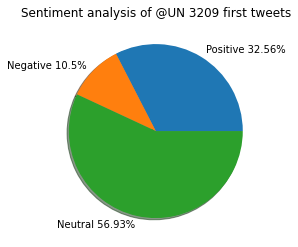

In [202]:
stemmed=sentiment(processed_tweets) # applied sentiment analysis to stemmed text

39.39 45.25 15.36


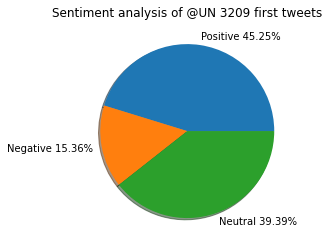

In [203]:
cleaned=sentiment(ct) # applied sentiment analysis to cleaned with regular expressions text, no stemming

In [204]:
cleaned

,Polarity,Subjectivity,CleanTweet,Sentiment
0,0.000000,0.000000,recognition justice development blackhistorymo...,Neutral
1,0.000000,0.000000,covid tragically exacerbated suffering insecur...,Negative
2,0.000000,0.000000,times crisis women leaders their communities f...,Neutral
3,0.102778,0.402778,spokesperson strongly condemns detention aung ...,Positive
4,0.000000,0.000000,united kingdom assumes presidency security cou...,Neutral
...,...,...,...,...
3204,0.275000,0.425000,charter signed years principles ring just true...,Positive
3205,0.162121,0.383333,champions gender equality every woman girl exe...,Positive
3206,0.136364,0.500000,this msmeday watch interactive webtv programme...,Positive
3207,0.100000,0.383333,partners clear explosive ordnance helping crea...,Positive


In [205]:
stemmed

,Polarity,Subjectivity,CleanTweet,Sentiment
0,0.000000,0.000000,recognit justic develop get underway monday op...,Neutral
1,-0.750000,0.750000,covid tragic exacerb suffer insecur face hundr...,Negative
2,0.000000,0.000000,time crisi women leader communiti frontlin res...,Neutral
3,0.433333,0.733333,spokesperson strong condemn detent aung presid...,Positive
4,0.000000,0.000000,unit kingdom assum presid secur council month ...,Neutral
...,...,...,...,...
3204,0.350000,0.650000,charter sign year principl ring true today nee...,Positive
3205,0.105519,0.346429,champion gender equal woman girl exercis human...,Positive
3206,0.136364,0.500000,msmeday watch interact webtv programm live fac...,Positive
3207,0.100000,0.383333,partner clear explos ordnanc help creat safegr...,Positive


In [206]:
j=pd.concat([cleaned, stemmed], axis=1)

In [207]:
j.head(30)

,Polarity,Subjectivity,CleanTweet,Sentiment,Polarity,Subjectivity,CleanTweet,Sentiment
0,0.000000,0.000000,recognition justice development blackhistorymo...,Neutral,0.000000,0.000000,recognit justic develop get underway monday op...,Neutral
1,0.000000,0.000000,covid tragically exacerbated suffering insecur...,Negative,-0.750000,0.750000,covid tragic exacerb suffer insecur face hundr...,Negative
2,0.000000,0.000000,times crisis women leaders their communities f...,Neutral,0.000000,0.000000,time crisi women leader communiti frontlin res...,Neutral
3,0.102778,0.402778,spokesperson strongly condemns detention aung ...,Positive,0.433333,0.733333,spokesperson strong condemn detent aung presid...,Positive
4,0.000000,0.000000,united kingdom assumes presidency security cou...,Neutral,0.000000,0.000000,unit kingdom assum presid secur council month ...,Neutral
5,0.286869,0.659596,women happy blackhistorymonth this month highl...,Negative,-0.166667,0.433333,women happi month highlight black women trailb...,Negative
6,1.000000,1.000000,champions earth take climateaction inspire def...,Positive,1.000000,1.000000,champion earth climateact inspir defend mobil ...,Positive
7,0.100000,0.400000,nearly children subjected child labour worldwi...,Negative,-0.033333,0.366667,near children subject child labour worldwid re...,Negative
8,0.000000,0.000000,climate crisis stopped amid covid19 delaying c...,Neutral,0.136364,0.500000,climat crisi stop amid covid delay climateact ...,Positive
9,0.200000,0.800000,time secure well being people economies societ...,Positive,0.000000,0.000000,time secur peopl economi societi planet possibl,Neutral


Let us check a few tweets and their sentiment results:

In [208]:
print("cleaned_tweet: \n ", j.iloc[19, 2], "   --", j.iloc[19, 3])
print("cleaned tweet + stemmed: \n", j.iloc[19,6], "   --", j.iloc[19, 7])
print("Original tweet: \n", df_UN.text[19])
# negative

cleaned_tweet: 
  colleague yvonne working beirut when vast explosion port killed small isaac    -- Negative
cleaned tweet + stemmed: 
 colleagu yvonn work beirut vast explos port kill small isaac    -- Negative
Original tweet: 
 RT @MelissaFleming: My @UNESCWA colleague @sas_yvonne was working in Beirut when the vast explosion at the port killed her small son Isaac.…


In [209]:
print("cleaned_tweet: \n ", j.iloc[6, 2], "   --", j.iloc[6, 3])
print("cleaned tweet + stemmed: \n", j.iloc[6,6], "   --", j.iloc[6, 7])
print("Original tweet: \n", df_UN.text[6])
#positive

cleaned_tweet: 
  champions earth take climateaction inspire defend mobilize tackle greatest environmental    -- Positive
cleaned tweet + stemmed: 
 champion earth climateact inspir defend mobil tackl greatest environment    -- Positive
Original tweet: 
 The Champions of the Earth take #ClimateAction to inspire, defend, mobilize and tackle the greatest environmental c… https://t.co/tpacZTMUZy


In [210]:
print("cleaned_tweet: \n ", j.iloc[7, 2], "   --", j.iloc[7, 3])
print("cleaned tweet + stemmed: \n", j.iloc[7,6], "   --", j.iloc[7, 7])
print("Original tweet: \n", df_UN.text[7])
# negative

cleaned_tweet: 
  nearly children subjected child labour worldwide resulting them being from schooling    -- Negative
cleaned tweet + stemmed: 
 near children subject child labour worldwid result school    -- Negative
Original tweet: 
 Nearly 1 in 10 children are subjected to child labour worldwide, resulting in them being cut off from schooling &amp; h… https://t.co/LinIVGftTc


In [211]:
print("cleaned_tweet: \n ", j.iloc[8, 2], "   --", j.iloc[8, 3])
print("cleaned tweet + stemmed: \n", j.iloc[8,6], "   --", j.iloc[8, 7])
print("Original tweet: \n", df_UN.text[8]) 
# should have been ratger negative

cleaned_tweet: 
  climate crisis stopped amid covid19 delaying climateaction costs livelihoods lives actnow    -- Neutral
cleaned tweet + stemmed: 
 climat crisi stop amid covid delay climateact cost livelihood live actnow    -- Positive
Original tweet: 
 The climate crisis has not stopped amid #COVID19. Delaying #ClimateAction costs livelihoods &amp; lives.

#ActNow to he… https://t.co/loVxMeOZYI


In [212]:
print("cleaned_tweet: \n ", j.iloc[123, 2], "   --", j.iloc[123, 3])
print("cleaned tweet + stemmed: \n", j.iloc[123,6], "   --", j.iloc[123, 7])
print("Original tweet: \n", df_UN.text[123])

cleaned_tweet: 
  assume that your bank your politician cares about this issue much they will more    -- Positive
cleaned tweet + stemmed: 
 assum bank politician care issu    -- Neutral
Original tweet: 
 Don’t assume that your bank or your politician cares about this issue as much as you do. They will, the more you ra… https://t.co/vrO01IydDt


In [213]:
# check tweets that have different sentiment results depending of the preprocessing steps 
not_same=j[cleaned.Sentiment!=stemmed.Sentiment]
not_same

,Polarity,Subjectivity,CleanTweet,Sentiment,Polarity,Subjectivity,CleanTweet,Sentiment
8,0.000000,0.000000,climate crisis stopped amid covid19 delaying c...,Neutral,0.136364,0.500000,climat crisi stop amid covid delay climateact ...,Positive
9,0.200000,0.800000,time secure well being people economies societ...,Positive,0.000000,0.000000,time secur peopl economi societi planet possibl,Neutral
12,0.350000,0.550000,equivalent million full time jobs have been lo...,Positive,0.000000,0.000000,equival million time job lose covid pandem accord,Neutral
15,0.100000,0.300000,sunday worldleprosyday ending stigma associate...,Positive,0.000000,0.000000,sunday worldleprosyday end stigma associ disea...,Neutral
17,0.125000,0.666667,racetoresilience putting people nature first p...,Positive,0.000000,0.000000,put peopl natur pursuit resili world,Neutral
...,...,...,...,...,...,...,...,...
3190,0.500000,0.500000,this year more than ever countries must honour...,Positive,0.000000,0.000000,year countri honour seafar recogn worker provid,Neutral
3194,0.500000,0.500000,migrant workers plunging into despair during c...,Positive,0.000000,0.000000,migrant worker plung despair covid crisi lose ...,Neutral
3196,0.500000,1.000000,women save date june teamed commission some yo...,Positive,0.000000,0.000000,women save date june team commiss favorit arti...,Neutral
3200,0.233333,0.466667,covid19 pandemic more negative impact than ant...,Positive,0.000000,0.000000,covid pandem negat impact anticip recoveri pro...,Neutral


In [214]:
# subjectivity of tweets cleaned with regular expressions
not_same.iloc[:, 1].describe()

count    759.000000
mean       0.434000
std        0.274456
min        0.000000
25%        0.250000
50%        0.450000
75%        0.562500
max        1.000000
Name: Subjectivity, dtype: float64

In [215]:
# subjectivity of tweets cleaned with regular expressions and stemmed
not_same.iloc[:, 5].describe()

count    759.000000
mean       0.137718
std        0.221633
min        0.000000
25%        0.000000
50%        0.000000
75%        0.295238
max        1.000000
Name: Subjectivity, dtype: float64

In [216]:
# sentiment (polarity) of tweets cleaned with regular expressions
not_same.iloc[:, 3].value_counts()

Positive    542
Neutral     217
Name: Sentiment, dtype: int64

In [217]:
# sentiment (polarity) of tweets cleaned with regular expressions and stemmed
not_same.iloc[:, 7].value_counts()

Neutral     542
Positive    217
Name: Sentiment, dtype: int64

In [218]:
print("cleaned_tweet: \n ", not_same.iloc[758, 2], "   --Neutral")
print("cleaned tweet + stemmed: \n", not_same.iloc[758,6], "   --Positive")
print("Original tweet: \n", df_UN.text[3208])
# positive / neutral ?

cleaned_tweet: 
  human rights equality dignity ideals laid charter signed years belong every    --Neutral
cleaned tweet + stemmed: 
 human right equal digniti ideal lay charter sign year belong    --Positive
Original tweet: 
 Human rights
Equality 
Dignity for all

The ideals laid out in the UN Charter, signed 75 years ago, belong to every… https://t.co/HZb4bSJD4O


In [219]:
print("cleaned_tweet: \n ", not_same.iloc[757, 2], "   --Positive")
print("cleaned tweet + stemmed: \n", not_same.iloc[757,6], "   --Neutral")
print("Original tweet: \n", df_UN.text[3200])
# negavite

cleaned_tweet: 
  covid19 pandemic more negative impact than anticipated recovery projected more gradual amidst    --Positive
cleaned tweet + stemmed: 
 covid pandem negat impact anticip recoveri project gradual amidst    --Neutral
Original tweet: 
 RT @IMFNews: The #COVID19 pandemic has had a more negative impact than anticipated, and the recovery is projected to be more gradual amidst…


In [220]:
print("cleaned_tweet: \n ", not_same.iloc[756, 2], "   --", not_same.iloc[756, 3])
print("cleaned tweet + stemmed: \n", not_same.iloc[756,6], "   --",  not_same.iloc[756, 7])
print("Original tweet: \n", df_UN.text[3196])
# positive 

cleaned_tweet: 
  women save date june teamed commission some your favorite artists globalgoaluni    -- Positive
cleaned tweet + stemmed: 
 women save date june team commiss favorit artist globalgoaluni    -- Neutral
Original tweet: 
 RT @UN_Women: SAVE THE DATE 📅: June 27

We've teamed up w/ @GlblCtzn, @EU_Commission &amp; some of your favorite artists for the #GlobalGoalUni…


In [221]:
print("cleaned_tweet: \n ", not_same.iloc[1, 2], "   --", not_same.iloc[1, 3])
print("cleaned tweet + stemmed: \n", not_same.iloc[1,6], "   --",  not_same.iloc[1, 7])
print("Original tweet: \n", df_UN.text[9])
# neutral / positive

cleaned_tweet: 
  time secure well being people economies societies planet possible    -- Positive
cleaned tweet + stemmed: 
 time secur peopl economi societi planet possibl    -- Neutral
Original tweet: 
 "Now is the time to secure the well-being of people, economies, societies and our planet. It is possible. So we mus… https://t.co/SPzgjyGEIf


In [222]:
print("cleaned_tweet: \n ", not_same.iloc[2, 2], "   --", not_same.iloc[2, 3])
print("cleaned tweet + stemmed: \n", not_same.iloc[2,6], "   --",  not_same.iloc[2, 7])
print("Original tweet: \n", df_UN.text[12])
# should have been negavite

cleaned_tweet: 
  equivalent million full time jobs have been lost covid19 pandemic according    -- Positive
cleaned tweet + stemmed: 
 equival million time job lose covid pandem accord    -- Neutral
Original tweet: 
 The equivalent of 225 million full-time jobs have been lost due to the #COVID19 pandemic, according to @ILO.

A slo… https://t.co/sJ3Iv3mYYT


# Machine Learning 


In [176]:
df_UN.head(10)

,tweet_id,created_at,text,retweet_count,favorite_count,in_reply_to_screen_name,source,followers_count,friends_count,popular
0,1356317393048506369,2021-02-01 19:04:00,Recognition\nJustice\nDevelopment\n\n#BlackHis...,47,158,NaN,TweetDeck,13428261,1184,0
1,1356302735780548608,2021-02-01 18:05:45,RT @UNmigration: “COVID-19 has tragically exac...,11,0,NaN,Twitter Web App,13428261,1184,0
2,1356287104679075840,2021-02-01 17:03:39,"In times of crisis, women are leaders in their...",86,222,NaN,Twitter for iPhone,13428261,1184,0
3,1356256620091736068,2021-02-01 15:02:30,RT @UN_Spokesperson: .@antonioguterres strongl...,306,0,NaN,Twitter Web App,13428261,1184,0
4,1356240214524624901,2021-02-01 13:57:19,The United Kingdom assumes the presidency of t...,115,445,NaN,Twitter for iPhone,13428261,1184,0
5,1356224683214053377,2021-02-01 12:55:36,RT @UN_Women: Happy #BlackHistoryMonth!\n\nThi...,256,0,NaN,Twitter Web App,13428261,1184,0
6,1356061204637048834,2021-02-01 02:06:00,The Champions of the Earth take #ClimateAction...,63,254,NaN,TweetDeck,13428261,1184,0
7,1356015151384682498,2021-01-31 23:03:00,Nearly 1 in 10 children are subjected to child...,134,354,NaN,TweetDeck,13428261,1184,0
8,1355971111163334657,2021-01-31 20:08:00,The climate crisis has not stopped amid #COVID...,98,287,NaN,TweetDeck,13428261,1184,0
9,1355925057881698306,2021-01-31 17:05:00,"""Now is the time to secure the well-being of p...",207,626,NaN,TweetDeck,13428261,1184,1


In [177]:
label=df_UN.popular.values

In [171]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_tweets).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, label, test_size=0.2, random_state=24)

In [180]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [181]:
predictions = text_classifier.predict(X_test)

In [182]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[524  18]
 [ 81  19]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       542
           1       0.51      0.19      0.28       100

    accuracy                           0.85       642
   macro avg       0.69      0.58      0.60       642
weighted avg       0.81      0.85      0.81       642

0.8457943925233645


In [232]:
TP=0
FP=0
TN=0
FN=0
for p, y in zip(predictions, y_test):
  if (p == 1) & (p ==y) :
      TP += 1
  elif (p == 1) & (p !=y):
      FP += 1
  elif (p == 0) & (p ==y):
      TN += 1
  else: FN += 1
print("True Positive = ", TP, ", False Positive =", FP , ", True Negavite = ", TN, ", False Negative =", FN)

True Positive =  19 , False Positive = 18 , True Negavite =  524 , False Negative = 81


In [185]:
from sklearn.naive_bayes import MultinomialNB
text_classifier2 = MultinomialNB().fit(X_train, y_train)

In [186]:
predictions_MNB = text_classifier2.predict(X_test)

In [187]:
print(confusion_matrix(y_test,predictions_MNB ))
print(classification_report(y_test,predictions_MNB ))
print(accuracy_score(y_test, predictions_MNB ))

[[542   0]
 [ 93   7]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       542
           1       1.00      0.07      0.13       100

    accuracy                           0.86       642
   macro avg       0.93      0.54      0.53       642
weighted avg       0.88      0.86      0.80       642

0.8551401869158879


In [233]:
print("True Positive = ", 7, ", False Positive =", 0 , ", True Negavite = ", 542, ", False Negative =", 93)

True Positive =  7 , False Positive = 0 , True Negavite =  542 , False Negative = 93


In [191]:
from sklearn.linear_model import SGDClassifier
text_classifier3 = SGDClassifier().fit(X_train, y_train)
predictions_SGD = text_classifier3.predict(X_test)

In [192]:
print(confusion_matrix(y_test,predictions_SGD  ))
print(classification_report(y_test,predictions_SGD  ))
print(accuracy_score(y_test, predictions_SGD  ))

[[528  14]
 [ 86  14]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       542
           1       0.50      0.14      0.22       100

    accuracy                           0.84       642
   macro avg       0.68      0.56      0.57       642
weighted avg       0.80      0.84      0.81       642

0.8442367601246106


In [236]:
print("True Positive = ", 14, ", False Positive =", 14, ", True Negavite = ", 528, ", False Negative =", 86)

True Positive =  14 , False Positive = 14 , True Negavite =  528 , False Negative = 86


In [193]:
from sklearn.linear_model import LogisticRegression
text_classifier4 = LogisticRegression().fit(X_train, y_train)
predictions_LR = text_classifier4.predict(X_test)

In [194]:
print(confusion_matrix(y_test,predictions_LR  ))
print(classification_report(y_test,predictions_LR  ))
print(accuracy_score(y_test, predictions_LR  ))

[[542   0]
 [ 99   1]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       542
           1       1.00      0.01      0.02       100

    accuracy                           0.85       642
   macro avg       0.92      0.51      0.47       642
weighted avg       0.87      0.85      0.78       642

0.8457943925233645


In [235]:
print("True Positive = ", 1, ", False Positive =", 0, ", True Negavite = ", 542, ", False Negative =", 99)

True Positive =  1 , False Positive = 0 , True Negavite =  542 , False Negative = 99


Conclusion: simple binary classification models yield quite good results with accuracy of 85% , maximum recall 19% with Random Forest(precision 51%) and maximum precision 100% with MultinomialNB (recall 7%) and LogisticRegression (recall 1%). Depending on the business requirements we could choose between better results of recall or precision, for example if we want to predict as much as possible tweets that are going to be popular we would go with Random Forest which predicts 19% of all popular tweets (actual==1). If we need to be as precise as possible, i.e. have minimum number of False Positive, then the best choise would be MultinominalNB which predicts 7% of actual popular tweets, but with 100% precision. 

# Part 2:  Topic modeling with  Latent Dirichlet Allocation technique (LDA) done on a larger dataset - movies reviews Kaggle dataset

# Download the dataset

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"katyalelas","key":"08f122d1e5d8801a1a8f23675739ce0b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 24.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 85.9MB/s]


In [7]:
!ls


imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


In [10]:
! unzip imdb-dataset-of-50k-movie-reviews.zip  -d imdb-dataset-of-50k-movie-reviews 

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv  


In [8]:
!pwd 


/content


In [11]:
reviews=pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [249]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Preprocessing

In [15]:
ct2=cleaning(reviews.review) # clean text

['other reviewers mentioned that after watching just episode hooked they right this exactly what happened with first thing that struck about brutality unflinching scenes violence which right from word trust this show faint hearted timid this show pulls punches with regards drugs violence hardcore classic word called that nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison where cells have glass fronts face inwards privacy high agenda city home many aryans muslims gangstas latinos christians italians irish more scuffles death stares dodgy dealings shady agreements never away would main appeal show fact that goes where other shows wouldn dare forget pretty pictures painted mainstream audiences forget charm forget romance doesn mess around first episode ever struck nasty surreal couldn ready watched more developed taste accustomed high levels graphic violence just violence injustice crooked guards sold nickel inmates kill order 

In [25]:
processed = []
for t in ct2:
    processed.append(preprocess(t, snowball)) # apply stemming, stopword removal, tokenization

In [29]:
print(processed[:2]) 

[['review', 'mention', 'watch', 'episod', 'hook', 'right', 'exact', 'happen', 'thing', 'strike', 'brutal', 'unflinch', 'scene', 'violenc', 'right', 'word', 'trust', 'faint', 'heart', 'timid', 'pull', 'punch', 'regard', 'drug', 'violenc', 'hardcor', 'classic', 'word', 'call', 'nicknam', 'give', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'main', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'citi', 'home', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffl', 'death', 'star', 'dodgi', 'deal', 'shadi', 'agreement', 'away', 'main', 'appeal', 'fact', 'go', 'show', 'wouldn', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget', 'charm', 'forget', 'romanc', 'mess', 'episod', 'strike', 'nasti', 'surreal', 'couldn', 'readi', 'watch', 'develop', 'tast', 'accustom', 'high', 'level', 'graphic', 'violenc', 'violenc', 'injustic', 'crook', 'guar

In [30]:
dictionary = gensim.corpora.Dictionary(processed) # create a dictionary object

In [31]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accustom
1 agenda
2 agreement
3 appeal
4 aryan
5 audienc
6 away
7 bitch
8 brutal
9 call
10 cell


In [32]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000) # remove extremes
bow_corpus = [dictionary.doc2bow(doc) for doc in processed] # bag of words collection (corpus) ##  contains each word’s token’s id along with its frequency count in the document.


[source](https://www.tutorialspoint.com/gensim/gensim_creating_a_dictionary.htm) # Gensim


In [257]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

In [33]:
document_num = 20
bow_doc_x = bow_corpus[document_num]
for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 22 ("death") appears 1 time.
Word 33 ("forget") appears 2 time.
Word 55 ("mention") appears 1 time.
Word 79 ("skill") appears 1 time.
Word 101 ("dream") appears 1 time.
Word 112 ("michael") appears 1 time.
Word 138 ("career") appears 1 time.
Word 151 ("jump") appears 1 time.
Word 152 ("killer") appears 1 time.
Word 153 ("laugh") appears 1 time.
Word 156 ("manag") appears 1 time.
Word 162 ("serial") appears 1 time.
Word 174 ("wear") appears 1 time.
Word 188 ("expect") appears 1 time.
Word 225 ("human") appears 1 time.
Word 236 ("portrait") appears 1 time.
Word 250 ("success") appears 1 time.
Word 324 ("band") appears 1 time.
Word 332 ("entertain") appears 1 time.
Word 346 ("pain") appears 1 time.
Word 380 ("base") appears 1 time.
Word 403 ("care") appears 1 time.
Word 435 ("unintent") appears 1 time.
Word 447 ("deliv") appears 1 time.
Word 451 ("evil") appears 1 time.
Word 462 ("kick") appears 1 time.
Word 485 ("shoot") appears 1 time.
Word 514 ("constant") appears 1 time.
Word 543

# Topic Modeling

In [39]:
lda_model =  gensim.models.LdaMulticore(bow_corpus,num_topics = 8, id2word = dictionary, passes = 10, workers = 2)

In [42]:
topics = lda_model.print_topics(num_words=4) # 8 topics
for topic in topics:
    print(topic)

(0, '0.019*"horror" + 0.007*"killer" + 0.005*"blood" + 0.005*"monster"')
(1, '0.018*"book" + 0.008*"read" + 0.007*"novel" + 0.005*"match"')
(2, '0.006*"american" + 0.005*"fight" + 0.004*"soldier" + 0.004*"alien"')
(3, '0.007*"famili" + 0.005*"wife" + 0.005*"father" + 0.004*"home"')
(4, '0.004*"beauti" + 0.004*"emot" + 0.003*"viewer" + 0.003*"famili"')
(5, '0.008*"worst" + 0.008*"laugh" + 0.007*"wast" + 0.006*"bore"')
(6, '0.011*"seri" + 0.008*"anim" + 0.007*"episod" + 0.006*"version"')
(7, '0.008*"danc" + 0.005*"actress" + 0.004*"sing" + 0.004*"jane"')



*   Topic 1 - horror movies
*   Topic 2 - movies based on books 
*   Topic 3 - american military movies 
*   Topic 4 - family movies
*   Topic 5 - probably good reviews 
*   Topic 6 - bad reviews 
*   Topic 7 - tv shows, anime 
*   Topic 8 - musicals 